In [1]:
import sys
import os

# Add the project root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [2]:
import numpy as np

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [4]:
data_pre_path = '../../data/' # change this path
# File paths
data_train_path = data_pre_path + 'train'
data_test_path = data_pre_path + 'test'
# Read dictionary
data_train_dict = unpickle(data_train_path)
data_test_dict = unpickle(data_test_path)
# Get data (change the coarse_labels if you want to use the 100 classes)
data_train = data_train_dict[b'data']
label_train = np.array(data_train_dict[b'coarse_labels'])
data_test = data_test_dict[b'data']
label_test = np.array(data_test_dict[b'coarse_labels'])

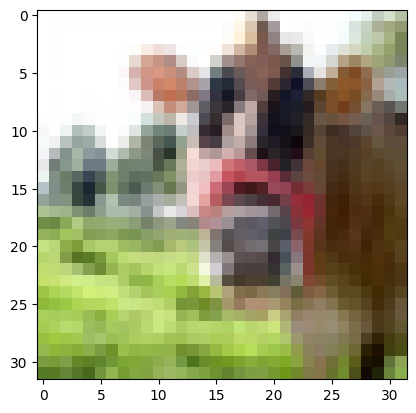

In [5]:
import matplotlib.pyplot as plt

img = data_train.reshape(50_000, 3, 32, 32).transpose(0, 2, 3, 1)[0]
plt.imshow(img)

In [6]:
from PIL import Image

Image.fromarray(img).save('img.png')


In [7]:
from torch.utils.data import DataLoader
from src.datasets.datasets import CIFAR
from src.datasets.transforms import transform

batch_size = 32
course_labels = True

train_data = CIFAR('../../data/train', course_labels, transform)
test_data = CIFAR('../../data/test', course_labels, transform)

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

/tmp/ipykernel_20613/3531982884.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  plt.imshow(img.T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781512..2.64].


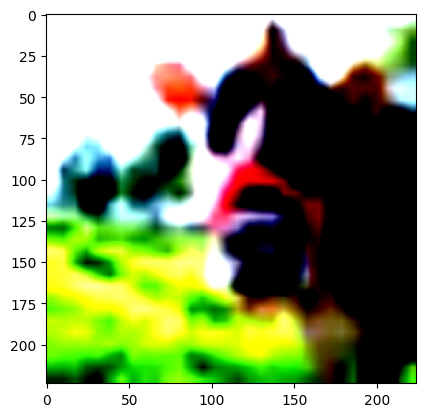

In [8]:
img, label = train_dl.dataset.__getitem__(0)
plt.imshow(img.T)   

In [9]:
import torch


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [10]:
from efficientnet_pytorch import EfficientNet
from torch import nn

# Load the EfficientNet-L2 model
model = EfficientNet.from_pretrained('efficientnet-b2')  # Change to 'efficientnet-b2' if L2 is not available

# Replace the classifier layer for your dataset
num_classes = 20
model._fc = nn.Linear(model._fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Loaded pretrained weights for efficientnet-b2


In [11]:
from torch import optim


loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [12]:
from tqdm import tqdm

from src.util.ml import save_model


def validate(
    epochs,
    model,
    loss_fn,
    test_dl,
    epoch,
):
    model.eval()
    val_running_loss = 0.0
    val_total = 0
    val_correct = 0

    with torch.no_grad():
        for i, data in enumerate(
            tqdm(test_dl, desc=f"Epoch {epoch + 1}/{epochs} - Validation")
        ):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_running_loss += loss.item()

            # Accuracy tracking during validation
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    return val_running_loss, val_total, val_correct


def train(
    epochs,
    model,
    loss_fn,
    optimizer,
    train_dl,
    test_dl,
):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train(True)
        running_loss = 0.0
        train_total = 0
        train_correct = 0

        # Training loop with progress bar
        for i, data in enumerate(
            tqdm(
                train_dl, desc=f"Epoch {epoch + 1}/{epochs} - Training", unit="batches"
            )
        ):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Accuracy tracking during training
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_dl)
        train_accuracy = 100 * train_correct / train_total
        print(
            f"Epoch {epoch+1}/{epoch} - Avg Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%"
        )

        # Validation phase
        val_running_loss, val_total, val_correct = validate(
            epochs, model, loss_fn, test_dl, epoch
        )

        avg_val_loss = val_running_loss / len(test_dl)
        val_accuracy = 100 * val_correct / val_total
        print(
            f"Epoch {epoch+1}/{epoch} - Avg Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n"
        )

        save_model(model, f"../../models/effnet-b2_epoch_{epoch+1}.pkl")

# Premature validation (first metrics)
model.eval()
val_running_loss, val_total, val_correct = validate(10, model, loss_fn, test_dl, -1)
avg_val_loss = val_running_loss / len(test_dl)
val_accuracy = 100 * val_correct / val_total
print(
    f"Epoch 0/10 - Avg Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n"
)
save_model(model, f"../../models/effnet-b2_epoch_0.pkl")

model.train()
train(
    10,
    model,
    loss_fn,
    optimizer,
    train_dl,
    test_dl,
)

Epoch 0/10 - Validation: 100%|██████████| 313/313 [00:37<00:00,  8.29it/s]


Epoch 0/10 - Avg Val Loss: 3.0149, Val Accuracy: 4.77%



Epoch 1/10 - Training: 100%|██████████| 1563/1563 [09:52<00:00,  2.64batches/s]


Epoch 1/0 - Avg Train Loss: 1.0568, Train Accuracy: 66.39%


Epoch 1/10 - Validation: 100%|██████████| 313/313 [00:35<00:00,  8.93it/s]


Epoch 1/0 - Avg Val Loss: 0.8499, Val Accuracy: 73.55%



Epoch 2/10 - Training: 100%|██████████| 1563/1563 [09:38<00:00,  2.70batches/s]


Epoch 2/1 - Avg Train Loss: 0.6670, Train Accuracy: 78.48%


Epoch 2/10 - Validation: 100%|██████████| 313/313 [00:35<00:00,  8.83it/s]


Epoch 2/1 - Avg Val Loss: 0.6613, Val Accuracy: 79.21%



Epoch 3/10 - Training: 100%|██████████| 1563/1563 [09:37<00:00,  2.71batches/s]


Epoch 3/2 - Avg Train Loss: 0.5207, Train Accuracy: 83.05%


Epoch 3/10 - Validation: 100%|██████████| 313/313 [00:35<00:00,  8.93it/s]


Epoch 3/2 - Avg Val Loss: 0.6449, Val Accuracy: 80.26%



Epoch 4/10 - Training: 100%|██████████| 1563/1563 [09:38<00:00,  2.70batches/s]


Epoch 4/3 - Avg Train Loss: 0.4297, Train Accuracy: 86.10%


Epoch 4/10 - Validation: 100%|██████████| 313/313 [00:35<00:00,  8.93it/s]


Epoch 4/3 - Avg Val Loss: 0.6878, Val Accuracy: 79.73%



Epoch 5/10 - Training: 100%|██████████| 1563/1563 [09:38<00:00,  2.70batches/s]


Epoch 5/4 - Avg Train Loss: 0.3644, Train Accuracy: 88.16%


Epoch 5/10 - Validation: 100%|██████████| 313/313 [00:35<00:00,  8.91it/s]


Epoch 5/4 - Avg Val Loss: 0.7155, Val Accuracy: 79.06%



Epoch 6/10 - Training: 100%|██████████| 1563/1563 [09:38<00:00,  2.70batches/s]


Epoch 6/5 - Avg Train Loss: 0.3094, Train Accuracy: 89.81%


Epoch 6/10 - Validation: 100%|██████████| 313/313 [00:35<00:00,  8.86it/s]


Epoch 6/5 - Avg Val Loss: 0.6325, Val Accuracy: 81.96%



Epoch 7/10 - Training: 100%|██████████| 1563/1563 [09:38<00:00,  2.70batches/s]


Epoch 7/6 - Avg Train Loss: 0.2686, Train Accuracy: 91.12%


Epoch 7/10 - Validation: 100%|██████████| 313/313 [00:35<00:00,  8.88it/s]


Epoch 7/6 - Avg Val Loss: 0.6520, Val Accuracy: 81.96%



Epoch 8/10 - Training: 100%|██████████| 1563/1563 [09:37<00:00,  2.70batches/s]


Epoch 8/7 - Avg Train Loss: 0.2398, Train Accuracy: 92.05%


Epoch 8/10 - Validation: 100%|██████████| 313/313 [00:35<00:00,  8.94it/s]


Epoch 8/7 - Avg Val Loss: 0.7058, Val Accuracy: 80.65%



Epoch 9/10 - Training: 100%|██████████| 1563/1563 [09:38<00:00,  2.70batches/s]


Epoch 9/8 - Avg Train Loss: 0.2176, Train Accuracy: 92.81%


Epoch 9/10 - Validation: 100%|██████████| 313/313 [00:34<00:00,  8.95it/s]


Epoch 9/8 - Avg Val Loss: 0.6765, Val Accuracy: 82.06%



Epoch 10/10 - Training: 100%|██████████| 1563/1563 [09:37<00:00,  2.71batches/s]


Epoch 10/9 - Avg Train Loss: 0.1914, Train Accuracy: 93.59%


Epoch 10/10 - Validation: 100%|██████████| 313/313 [00:35<00:00,  8.93it/s]


Epoch 10/9 - Avg Val Loss: 0.7036, Val Accuracy: 81.66%

